In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the metadata, weather, and electricity consumption data
metadata = pd.read_csv('metadata.csv')
weather = pd.read_csv('weather.csv')
electricity = pd.read_csv('electricity_cleaned.csv')

# Handle missing values in the weather data
weather['precipDepth1HR'] = weather['precipDepth1HR'].replace(-1.0, np.nan)
weather['precipDepth6HR'] = weather['precipDepth6HR'].replace(-1.0, np.nan)

# Interpolate missing values for cloudCoverage
weather['cloudCoverage'] = weather['cloudCoverage'].interpolate()

# Replace windDirection and windSpeed where both are 0.0 with NaN
weather.loc[(weather['windDirection'] == 0.0) & (weather['windSpeed'] == 0.0), ['windDirection', 'windSpeed']] = np.nan

# Convert timestamps to datetime objects and set as index where appropriate
weather['timestamp'] = pd.to_datetime(weather['timestamp'], errors='coerce')
electricity['timestamp'] = pd.to_datetime(electricity['timestamp'], errors='coerce')

# Set timestamp as index for electricity data
electricity.set_index('timestamp', inplace=True)

# Display first few rows to verify the preprocessing
print("Metadata:\n", metadata.head())
print("\nWeather Data:\n", weather.head())
print("\nElectricity Data:\n", electricity.head())

Metadata:
                  building_id  site_id  building_id_kaggle  site_id_kaggle  \
0       Panther_lodging_Dean  Panther                 NaN             0.0   
1     Panther_lodging_Shelia  Panther                 NaN             0.0   
2      Panther_lodging_Ricky  Panther                 NaN             0.0   
3  Panther_education_Rosalie  Panther                 0.0             0.0   
4    Panther_education_Misty  Panther                 1.0             0.0   

     primaryspaceusage sub_primaryspaceusage    sqm     sqft        lat  \
0  Lodging/residential        Residence Hall  508.8   5477.0  28.517689   
1  Lodging/residential        Residence Hall  929.0  10000.0  28.517689   
2  Lodging/residential        Residence Hall  483.1   5200.0  28.517689   
3            Education              Research  690.5   7432.0  28.517689   
4            Education              Research  252.7   2720.0  28.517689   

         lng  ... yearbuilt date_opened numberoffloors occupants  \
0 -81.3

In [3]:
# 1. How many unique sites and buildings are in the dataset?
unique_sites = metadata['site_id'].nunique()
unique_buildings = metadata['building_id'].nunique()

print(f"1. How many unique sites are in the dataset? {unique_sites}")
print(f"How many unique buildings are in the dataset? {unique_buildings}")

# 2. What is the date range of the weather data?
weather['timestamp'] = pd.to_datetime(weather['timestamp'], errors='coerce')
date_min = weather['timestamp'].min()
date_max = weather['timestamp'].max()

print(f"\n2. What is the date range of the weather data? From {date_min} to {date_max}")

# 3. How many weather variables are recorded, and what are they?
weather_columns = weather.columns.drop(['timestamp', 'site_id'])
num_weather_variables = len(weather_columns)
weather_variables = list(weather_columns)

print(f"\n3. How many weather variables are recorded? {num_weather_variables}")
print(f"What are the weather variables? {weather_variables}")

# 4. What percentage of values are missing in the cloudCoverage column of the weather data?
missing_cloud_coverage = weather['cloudCoverage'].isna().sum()
total_cloud_coverage = len(weather['cloudCoverage'])
percent_missing_cloud_coverage = (missing_cloud_coverage / total_cloud_coverage) * 100

print(f"\n4. What percentage of values are missing in the cloudCoverage column? {percent_missing_cloud_coverage:.2f}%")

# Checking for missing values in metadata and weather data
metadata_missing_values = metadata.isna().sum()
weatherdata_missing_values = weather.isna().sum()

print(metadata_missing_values, weatherdata_missing_values)


1. How many unique sites are in the dataset? 19
How many unique buildings are in the dataset? 1636

2. What is the date range of the weather data? From 2016-01-01 00:00:00 to 2017-12-31 23:00:00

3. How many weather variables are recorded? 8
What are the weather variables? ['airTemperature', 'cloudCoverage', 'dewTemperature', 'precipDepth1HR', 'precipDepth6HR', 'seaLvlPressure', 'windDirection', 'windSpeed']

4. What percentage of values are missing in the cloudCoverage column? 0.00%
building_id                 0
site_id                     0
building_id_kaggle        187
site_id_kaggle             37
primaryspaceusage          21
sub_primaryspaceusage      21
sqm                         0
sqft                        0
lat                       237
lng                       237
timezone                    0
electricity                58
hotwater                 1451
chilledwater             1081
steam                    1266
water                    1490
irrigation               1599
s

In [6]:
# 5. Handling missing values in metadata and weather data

# Handling missing values in metadata
# Filling missing values in 'primaryspaceusage' and 'sub_primaryspaceusage' with the mode as they are categorical fields
metadata['primaryspaceusage'].fillna(metadata['primaryspaceusage'].mode()[0], inplace=True)
metadata['sub_primaryspaceusage'].fillna(metadata['sub_primaryspaceusage'].mode()[0], inplace=True)

# Filling 'lat' and 'lng' with mean latitude and longitude per 'site_id'
metadata['lat'] = metadata.groupby('site_id')['lat'].transform(lambda x: x.fillna(x.mean()))
metadata['lng'] = metadata.groupby('site_id')['lng'].transform(lambda x: x.fillna(x.mean()))

# Filling 'electricity', 'hotwater', 'chilledwater', 'steam', 'water' with the mean per primary space usage
for col in ['electricity', 'hotwater', 'chilledwater', 'steam', 'water']:
    metadata[col] = pd.to_numeric(metadata[col], errors='coerce')
    metadata[col] = metadata.groupby('primaryspaceusage')[col].transform(lambda x: x.fillna(x.mean()))

# Filling 'gas', 'solar', 'irrigation' with 0 to indicate no data, if applicable
for col in ['gas', 'solar', 'irrigation']:
    metadata[col].fillna(0, inplace=True)

# Filling missing 'heatingtype' and 'yearbuilt' based on the mode per primary space usage
metadata['heatingtype'] = metadata.groupby('primaryspaceusage')['heatingtype'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "Unknown"))
metadata['yearbuilt'] = metadata.groupby('primaryspaceusage')['yearbuilt'].transform(lambda x: x.fillna(x.mean()))

# Setting high-missing-value columns such as 'leed_level' and 'energystarscore' as "Unknown"
for col in ['leed_level', 'energystarscore', 'occupants', 'eui', 'site_eui', 'source_eui']:
    metadata[col].fillna("Unknown", inplace=True)

# Interpolating for 'airTemperature', 'dewTemperature'
weather['airTemperature'] = weather['airTemperature'].interpolate(method='linear')
weather['dewTemperature'] = weather['dewTemperature'].interpolate(method='linear')

# Interpolating 'seaLvlPressure', 'windDirection', 'windSpeed' as they are time series variables
weather['seaLvlPressure'] = weather['seaLvlPressure'].interpolate(method='linear')
weather['windDirection'] = weather['windDirection'].interpolate(method='linear')
weather['windSpeed'] = weather['windSpeed'].interpolate(method='linear')

# Fill remaining missing 'precipDepth1HR' and 'precipDepth6HR' with 0, if no data is preferred
weather['precipDepth1HR'].fillna(0, inplace=True)
weather['precipDepth6HR'].fillna(0, inplace=True)

print("\nSummary of missing values after handling:\n")
print("Metadata missing values:")
print(metadata.isna().sum())

print("\nWeather data missing values:")
print(weather.isna().sum())



Summary of missing values after handling:

Metadata missing values:
building_id                 0
site_id                     0
building_id_kaggle        187
site_id_kaggle             37
primaryspaceusage           0
sub_primaryspaceusage       0
sqm                         0
sqft                        0
lat                       237
lng                       237
timezone                    0
electricity              1636
hotwater                 1636
chilledwater             1636
steam                    1636
water                    1636
irrigation                  0
solar                       0
gas                         0
industry                 1057
subindustry              1057
heatingtype                 0
yearbuilt                  11
date_opened              1615
numberoffloors           1195
occupants                   0
energystarscore             0
eui                         0
site_eui                    0
source_eui                  0
leed_level                  0
r

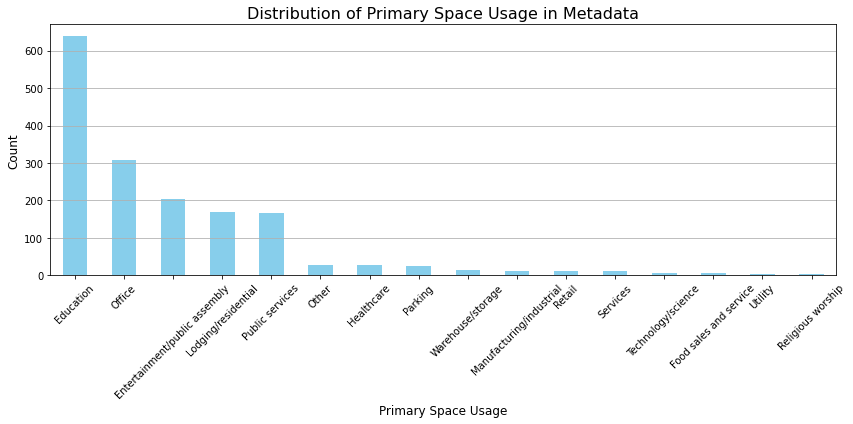

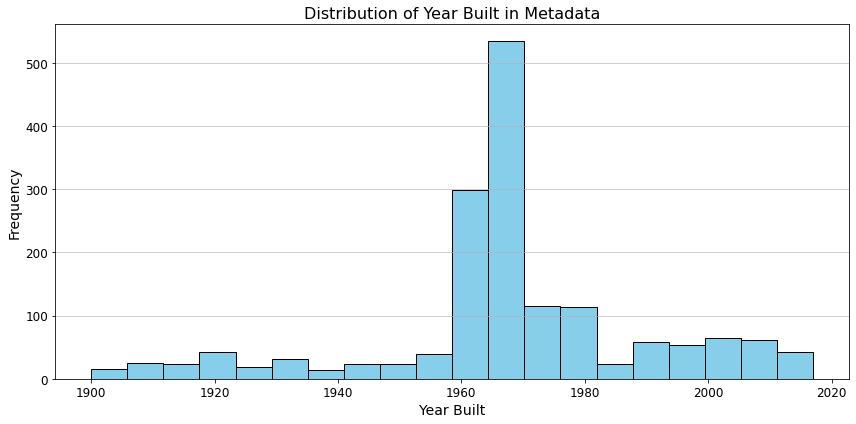

In [11]:
import matplotlib.pyplot as plt
# Create a bar plot for the distribution of primary use in the metadata DataFrame

# Check if the column 'primaryspaceusage' exists
if 'primaryspaceusage' in metadata.columns:
    # Count occurrences of each unique value in primaryspaceusage
    usage_counts = metadata['primaryspaceusage'].value_counts()
    
    # Create the bar plot
    plt.figure(figsize=(12, 6))
    usage_counts.plot(kind='bar', color='skyblue')
    
    # Adding labels and title
    plt.xlabel('Primary Space Usage', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Distribution of Primary Space Usage in Metadata', fontsize=16)
    plt.xticks(rotation=45)  
    plt.grid(axis='y')  
    plt.tight_layout()  
    plt.show()



# Check if the column 'yearbuilt' exists
if 'yearbuilt' in metadata.columns:
    # Create the histogram
    plt.figure(figsize=(12, 6))
    plt.hist(metadata['yearbuilt'].dropna(), bins=20, color='skyblue', edgecolor='black')  
    
    # Adding labels and title
    plt.xlabel('Year Built', fontsize=14)  
    plt.ylabel('Frequency', fontsize=14)  
    plt.title('Distribution of Year Built in Metadata', fontsize=16)  
    
    # Adding grid for better visualization
    plt.grid(axis='y', alpha=0.75)  
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)  
    plt.tight_layout()  
    plt.show()
else:
    print("Column 'yearbuilt' not found in metadata DataFrame.")

C:\Users\mahip\AppData\Local\Temp/ipykernel_33404/614217125.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent clipping


<Figure size 720x576 with 0 Axes>

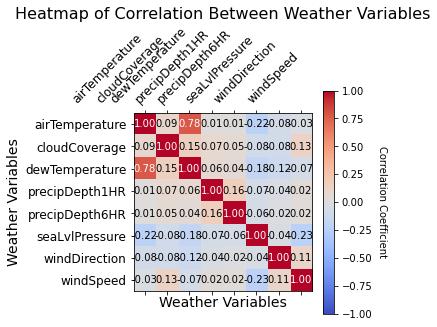

In [12]:
# Calculate the correlation matrix directly using the relevant columns
correlation_matrix = weather[['airTemperature', 'cloudCoverage', 
                               'dewTemperature', 'precipDepth1HR', 
                               'precipDepth6HR', 'seaLvlPressure', 
                               'windDirection', 'windSpeed']].corr()

# Create a heatmap using matplotlib
plt.figure(figsize=(10, 8))
cax = plt.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Add color bar
cbar = plt.colorbar(cax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=15)

# Set the ticks and labels
plt.xticks(ticks=np.arange(len(correlation_matrix.columns)), 
           labels=correlation_matrix.columns, rotation=45, ha='right', fontsize=12)
plt.yticks(ticks=np.arange(len(correlation_matrix.columns)), 
           labels=correlation_matrix.columns, fontsize=12)

# Adding titles and labels
plt.title('Heatmap of Correlation Between Weather Variables', fontsize=16)
plt.xlabel('Weather Variables', fontsize=14)
plt.ylabel('Weather Variables', fontsize=14)

# Display the correlation values in each cell
for (i, j), val in np.ndenumerate(correlation_matrix):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black' if abs(val) < 0.5 else 'white')

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [26]:
# What are the top 5 most common building types (primaryspaceusage) in the dataset?
top_building_types = metadata['primaryspaceusage'].value_counts().head(5)
print("Top 5 most common building types:")
print(top_building_types)

# What is the average age of buildings in the dataset?
current_year = 2024  # Update this to the current year
average_age = current_year - metadata['yearbuilt'].mean()
print(f"Average age of buildings: {average_age:.2f} years")

# Which weather variable has the strongest correlation with air temperature?
air_temp_correlation = correlation_matrix['airTemperature'].drop('airTemperature')  # Exclude self-correlation
strongest_correlation_variable = air_temp_correlation.idxmax()
strongest_correlation_value = air_temp_correlation.max()

print(f"The weather variable with the strongest correlation with air temperature is {strongest_correlation_variable} with a correlation of {strongest_correlation_value:.2f}.")



Top 5 most common building types:
Education                        638
Office                           307
Entertainment/public assembly    204
Lodging/residential              168
Public services                  166
Name: primaryspaceusage, dtype: int64
Average age of buildings: 55.61 years
The weather variable with the strongest correlation with air temperature is dewTemperature with a correlation of 0.78.
